In [1]:
!pip install japanize_matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 32.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=7aa57879500a798a6097476483a2ee8a44cafe57e073771aadee4f4685fbdfb9
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize_matplotlib


In [2]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from pathlib import Path
from glob import glob

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split as TTS

import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor as mor
from sklearn.metrics import mean_squared_error as MAE
from sklearn.model_selection import KFold
import japanize_matplotlib

path_start = Path("/content/drive/MyDrive/Nishika/Mansion_2023_spring")

Mounted at /content/drive


In [3]:
train = pd.read_csv(path_start/"input/df_train.csv", index_col=0)
test = pd.read_csv(path_start/"input/test.csv", index_col=0)
sample = pd.read_csv(path_start/"input/sample_submission.csv")

df_ConCat = pd.concat([train, test])
print(df_ConCat.shape)

(784713, 28)


## 特徴量の削除

In [4]:
Fvalue = lambda x: df_ConCat.drop(x, axis=1)
List_del = ["取引時点", "市区町村名", "間取り", "種類",
            "前面道路：方位", "前面道路：種類",	"前面道路：幅員（ｍ）", "地域", "土地の形状",
            "間口", "建物の構造", "延床面積（㎡）", "用途", "取引の事情等",
            "最寄駅：名称"]

for c in List_del:
  df_ConCat = df_ConCat.drop(c, axis=1)
display(df_ConCat.shape)
df_ConCat.head()

(784713, 13)

,ID,市区町村コード,都道府県名,地区名,最寄駅：距離（分）,面積（㎡）,建築年,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,改装,取引価格（総額）_log
0,8067540,8217,茨城県,野々井,13,70,1996.0,NaN,第１種住居地域,60.0,200.0,未改装,6.977724
1,8027265,8219,茨城県,ひたち野東,8,70,1998.0,住宅,第２種中高層住居専用地域,60.0,200.0,未改装,7.255273
2,8061526,8220,茨城県,苅間,4,105,2009.0,NaN,商業地域,80.0,400.0,未改装,7.556303
3,8086147,8220,茨城県,並木,75,100,2007.0,NaN,第１種中高層住居専用地域,60.0,200.0,未改装,7.380211
4,8049498,8224,茨城県,ひがし野,8,95,2009.0,住宅,近隣商業地域,80.0,200.0,未改装,7.518514


## 標準化

In [5]:
List_std = ["最寄駅：距離（分）", "面積（㎡）", "建ぺい率（％）", "容積率（％）"]
scaler = StandardScaler()
scaler.fit(df_ConCat[List_std])
df_ConCat[List_std] = scaler.transform(df_ConCat[List_std])
df_ConCat.head()

,ID,市区町村コード,都道府県名,地区名,最寄駅：距離（分）,面積（㎡）,建築年,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,改装,取引価格（総額）_log
0,8067540,8217,茨城県,野々井,0.144049,0.431679,1996.0,NaN,第１種住居地域,-0.741730,-0.695601,未改装,6.977724
1,8027265,8219,茨城県,ひたち野東,-0.266625,0.431679,1998.0,住宅,第２種中高層住居専用地域,-0.741730,-0.695601,未改装,7.255273
2,8061526,8220,茨城県,苅間,-0.595164,1.726269,2009.0,NaN,商業地域,1.177623,0.650409,未改装,7.556303
3,8086147,8220,茨城県,並木,5.236408,1.541328,2007.0,NaN,第１種中高層住居専用地域,-0.741730,-0.695601,未改装,7.380211
4,8049498,8224,茨城県,ひがし野,-0.266625,1.356387,2009.0,住宅,近隣商業地域,1.177623,-0.695601,未改装,7.518514


## 特徴量100個に絞る

In [6]:
for i in glob(str(path_start/"TargetEncoding/*.csv")):
  df_ConCat = pd.merge(df_ConCat, pd.read_csv(i), on="ID", how="left")
df_ConCat.shape

(784713, 121)

In [7]:
list_handred = pd.read_csv(path_start/"my_list_50.csv", header=None).values.tolist()
flattened = [x for row in list_handred for x in row]
display(len(flattened))
display(flattened)

50

['地区名',
 '建築年',
 '面積（㎡）',
 '都道府県名',
 '市区町村名_TE面積（㎡）',
 '最寄駅：距離（分）',
 '市区町村コード',
 '改装',
 '取引時点_TE取引時期_年四半期',
 '市区町村名_TE最寄駅：距離（分）',
 '間取り_TE取引時期_四半期',
 '市区町村名_TE取引時期_四半期',
 '取引時点_TE取引時期_年',
 '市区町村名_TE容積率（％）',
 'ID',
 '取引時点_TE建築年',
 '最寄駅：名称_TE容積率（％）',
 '地区名_TE最寄駅：距離（分）',
 '市区町村名_TE取引時期_年',
 '市区町村名_TE取引時期_年四半期',
 '市区町村名_TE取引-建築',
 '今後の利用目的',
 '取引の事情等_TE取引時期_四半期',
 '都市計画',
 '取引時点_TE面積（㎡）',
 '都道府県名_TE面積（㎡）',
 '市区町村名_TE建築年',
 '容積率（％）',
 '取引時点_TE取引-建築',
 '最寄駅：名称_TE建ぺい率（％）',
 '取引時点_TE最寄駅：距離（分）',
 '取引の事情等_TE建築年',
 '最寄駅：名称_TE取引時期_四半期',
 '市区町村名_TE建ぺい率（％）',
 '取引時点_TE建ぺい率（％）',
 '地区名_TE建築年',
 '取引の事情等_TE容積率（％）',
 '最寄駅：名称_TE取引-建築',
 '建物の構造_TE最寄駅：距離（分）',
 '都市計画_TE最寄駅：距離（分）',
 '間取り_TE取引時期_年',
 '最寄駅：名称_TE最寄駅：距離（分）',
 '取引の事情等_TE取引時期_年',
 '地区名_TE容積率（％）',
 '最寄駅：名称_TE取引時期_年四半期',
 '取引時点_TE容積率（％）',
 '地区名_TE取引-建築',
 '最寄駅：名称_TE面積（㎡）',
 '取引の事情等_TE面積（㎡）',
 '今後の利用目的_TE面積（㎡）']

In [8]:
df_ConCat2 = pd.concat([df_ConCat[["取引価格（総額）_log"]], df_ConCat[flattened]], axis=1)
df_ConCat2.head()

,取引価格（総額）_log,地区名,建築年,面積（㎡）,都道府県名,市区町村名_TE面積（㎡）,最寄駅：距離（分）,市区町村コード,改装,取引時点_TE取引時期_年四半期,...,間取り_TE取引時期_年,最寄駅：名称_TE最寄駅：距離（分）,取引の事情等_TE取引時期_年,地区名_TE容積率（％）,最寄駅：名称_TE取引時期_年四半期,取引時点_TE容積率（％）,地区名_TE取引-建築,最寄駅：名称_TE面積（㎡）,取引の事情等_TE面積（㎡）,今後の利用目的_TE面積（㎡）
0,6.977724,野々井,1996.0,0.431679,茨城県,0.201441,0.144049,8217,未改装,-1.580274,...,-0.042201,-0.051169,0.01425,-0.433236,-0.096591,-0.102286,0.026846,0.105338,-0.002202,0.025406
1,7.255273,ひたち野東,1998.0,0.431679,茨城県,0.506946,-0.266625,8219,未改装,0.784888,...,-0.042201,-0.519268,0.01425,0.203528,0.046625,0.028981,-0.704945,0.641592,-0.002202,0.008770
2,7.556303,苅間,2009.0,1.726269,茨城県,1.006775,-0.595164,8220,未改装,-0.666462,...,-0.042201,-0.587841,0.01425,0.306295,0.463295,-0.036798,-0.888053,1.280655,-0.002202,0.025406
3,7.380211,並木,2007.0,1.541328,茨城県,1.006775,5.236408,8220,未改装,-0.397693,...,-0.103538,1.064501,0.01425,-0.416577,-0.048201,-0.043977,0.196723,0.967881,-0.002202,0.025406
4,7.518514,ひがし野,2009.0,1.356387,茨城県,0.690122,-0.266625,8224,未改装,0.731134,...,-0.103538,-0.262707,0.01425,-0.690946,0.420120,0.019880,-0.926995,0.736961,-0.002202,0.008770


## 特徴量追加

In [9]:
for i in glob(str(path_start/"LoE/*.csv")):
  df_ConCat2 = pd.merge(df_ConCat2, pd.read_csv(i), on="ID", how="left")
display(df_ConCat2.shape)
display(df_ConCat2.head())

(784713, 210)

,取引価格（総額）_log,地区名,建築年,面積（㎡）,都道府県名,市区町村名_TE面積（㎡）,最寄駅：距離（分）,市区町村コード,改装,取引時点_TE取引時期_年四半期,...,地区名_LoE駅別乗降客数_2022,最寄駅：名称_LoE駅別乗降客数_2022,間取り_LoE駅別乗降客数_2022,建物の構造_LoE駅別乗降客数_2022,用途_LoE駅別乗降客数_2022,今後の利用目的_LoE駅別乗降客数_2022,都市計画_LoE駅別乗降客数_2022,取引時点_LoE駅別乗降客数_2022,改装_LoE駅別乗降客数_2022,取引の事情等_LoE駅別乗降客数_2022
0,6.977724,野々井,1996.0,0.431679,茨城県,0.201441,0.144049,8217,未改装,-1.580274,...,7.301799e-17,7.301799e-17,7.301799e-17,7.301799e-17,7.301799e-17,7.301799e-17,7.301799e-17,7.301799e-17,7.301799e-17,7.301799e-17
1,7.255273,ひたち野東,1998.0,0.431679,茨城県,0.506946,-0.266625,8219,未改装,0.784888,...,7.301799e-17,7.301799e-17,-3.153441e-01,-3.153441e-01,-3.153441e-01,7.301799e-17,7.301799e-17,7.301799e-17,-3.153441e-01,-3.153441e-01
2,7.556303,苅間,2009.0,1.726269,茨城県,1.006775,-0.595164,8220,未改装,-0.666462,...,7.301799e-17,7.301799e-17,-3.498224e-01,-3.498224e-01,-3.498224e-01,-3.153441e-01,7.301799e-17,7.301799e-17,-3.498224e-01,-3.498224e-01
3,7.380211,並木,2007.0,1.541328,茨城県,1.006775,5.236408,8220,未改装,-0.397693,...,7.301799e-17,7.301799e-17,7.301799e-17,-3.663939e-01,-3.663939e-01,-3.489322e-01,7.301799e-17,7.301799e-17,-3.663939e-01,-3.663939e-01
4,7.518514,ひがし野,2009.0,1.356387,茨城県,0.690122,-0.266625,8224,未改装,0.731134,...,7.301799e-17,7.301799e-17,-4.021073e-02,-3.091994e-01,7.301799e-17,-2.093895e-01,7.301799e-17,7.301799e-17,-3.091994e-01,-3.091994e-01


## ラベルエンコーディング

In [10]:
List_Encode = []
for i, t in enumerate(df_ConCat2.dtypes):
  if t!="float64" and t!="int64":
    List_Encode.append(df_ConCat2.columns[i])

List_Encode

['地区名', '都道府県名', '改装', '今後の利用目的', '都市計画']

In [11]:
for c in List_Encode:
  le = LabelEncoder()
  le.fit(df_ConCat2[c])
  df_ConCat2[c] = le.transform(df_ConCat2[c])

## 分割

In [12]:
if df_ConCat2["取引価格（総額）_log"].isna().sum()!=0:
  test = df_ConCat2[df_ConCat2["取引価格（総額）_log"].isna()==True]
  train = df_ConCat2[df_ConCat2["取引価格（総額）_log"].isna()!=True]
else:
  test = df_ConCat2[df_ConCat2["取引価格（総額）_log"]==0]
  train = df_ConCat2[df_ConCat2["取引価格（総額）_log"]!=0]

In [13]:
aim = "取引価格（総額）_log"
df_y = train[aim]
df_x = train.drop([aim], axis=1)
test = test.drop([aim], axis=1)
df_x.head()

,地区名,建築年,面積（㎡）,都道府県名,市区町村名_TE面積（㎡）,最寄駅：距離（分）,市区町村コード,改装,取引時点_TE取引時期_年四半期,市区町村名_TE最寄駅：距離（分）,...,地区名_LoE駅別乗降客数_2022,最寄駅：名称_LoE駅別乗降客数_2022,間取り_LoE駅別乗降客数_2022,建物の構造_LoE駅別乗降客数_2022,用途_LoE駅別乗降客数_2022,今後の利用目的_LoE駅別乗降客数_2022,都市計画_LoE駅別乗降客数_2022,取引時点_LoE駅別乗降客数_2022,改装_LoE駅別乗降客数_2022,取引の事情等_LoE駅別乗降客数_2022
0,11184,1996.0,0.431679,38,0.201441,0.144049,8217,1,-1.580274,0.065247,...,7.301799e-17,7.301799e-17,7.301799e-17,7.301799e-17,7.301799e-17,7.301799e-17,7.301799e-17,7.301799e-17,7.301799e-17,7.301799e-17
1,80,1998.0,0.431679,38,0.506946,-0.266625,8219,1,0.784888,-0.405586,...,7.301799e-17,7.301799e-17,-3.153441e-01,-3.153441e-01,-3.153441e-01,7.301799e-17,7.301799e-17,7.301799e-17,-3.153441e-01,-3.153441e-01
2,9896,2009.0,1.726269,38,1.006775,-0.595164,8220,1,-0.666462,0.892265,...,7.301799e-17,7.301799e-17,-3.498224e-01,-3.498224e-01,-3.498224e-01,-3.153441e-01,7.301799e-17,7.301799e-17,-3.498224e-01,-3.498224e-01
3,822,2007.0,1.541328,38,1.006775,5.236408,8220,1,-0.397693,0.892265,...,7.301799e-17,7.301799e-17,7.301799e-17,-3.663939e-01,-3.663939e-01,-3.489322e-01,7.301799e-17,7.301799e-17,-3.663939e-01,-3.663939e-01
4,79,2009.0,1.356387,38,0.690122,-0.266625,8224,1,0.731134,-0.320855,...,7.301799e-17,7.301799e-17,-4.021073e-02,-3.091994e-01,7.301799e-17,-2.093895e-01,7.301799e-17,7.301799e-17,-3.091994e-01,-3.091994e-01


In [14]:
test.head()

,地区名,建築年,面積（㎡）,都道府県名,市区町村名_TE面積（㎡）,最寄駅：距離（分）,市区町村コード,改装,取引時点_TE取引時期_年四半期,市区町村名_TE最寄駅：距離（分）,...,地区名_LoE駅別乗降客数_2022,最寄駅：名称_LoE駅別乗降客数_2022,間取り_LoE駅別乗降客数_2022,建物の構造_LoE駅別乗降客数_2022,用途_LoE駅別乗降客数_2022,今後の利用目的_LoE駅別乗降客数_2022,都市計画_LoE駅別乗降客数_2022,取引時点_LoE駅別乗降客数_2022,改装_LoE駅別乗降客数_2022,取引の事情等_LoE駅別乗降客数_2022
765412,4280,2016.0,0.616621,4,0.365548,-0.841569,1101,1,1.591193,-0.092956,...,-0.498208,-0.656583,-0.073431,-0.009103,-0.016633,0.061050,0.129305,7.301799e-17,0.004702,0.003195
765413,4280,2012.0,0.616621,4,0.365548,-0.677299,1101,1,1.591193,-0.092956,...,-0.498627,-0.656583,0.057507,-0.009104,-0.016641,-0.011127,0.129301,-3.286789e-01,0.004701,0.003194
765414,4280,1984.0,0.061796,4,0.365548,-0.759434,1101,1,1.644947,-0.092956,...,-0.499045,-0.656721,0.057501,0.025508,-0.016649,-0.011128,0.129298,7.301799e-17,0.004700,0.003193
765415,4280,1986.0,-1.232794,4,0.365548,-0.759434,1101,1,1.644947,-0.092956,...,-0.499461,-0.656722,0.155905,-0.009106,-0.016657,-0.011130,0.129294,-3.286789e-01,0.004698,0.003192
765416,4280,2016.0,0.616621,4,0.365548,-0.841569,1101,1,1.644947,-0.092956,...,-0.499874,-0.656723,-0.073433,-0.009107,-0.016664,-0.011132,0.129290,-4.382385e-01,0.004697,0.003191


## 学習

In [15]:
#kf = KFold(n_splits=5, shuffle=True, random_state=71)
#models = []

# ハイパーパラメータの調整
params = {'boosting_type': 'gbdt',
          "objective": "regression_l1",
          "learning_rate": 0.2,
          "reg_alpha": 0.1,
          "reg_lambda": 0.1,
          "random_state": 71,
          "max_depth": 5,
          "n_estimators": 1000,
          "colsample_bytree": 1.0,
          "colsample_bylevel": 0.3,
          "lambda_l1": 0.0001,
          'metrics': 'mae',
          'learning_rate': 0.1}
num_round = 100

In [16]:
x_df_train, x_df_val, y_df_train, y_df_val = TTS(df_x, df_y, test_size=0.2, random_state=71)
lgb_train = lgb.Dataset(x_df_train, y_df_train)
lgb_val = lgb.Dataset(x_df_val, y_df_val)
evaluation_results = {}

model = lgb.train(params, lgb_train,
                  num_boost_round=num_round,
                  valid_sets=[lgb_train, lgb_val],
                  categorical_feature=List_Encode,
                  evals_result=evaluation_results,   # 学習の経過を保存
                  early_stopping_rounds=20,          # アーリーストッピング
                  verbose_eval=1)

va_pred = model.predict(x_df_val)
score = MAE(np.array(y_df_val), va_pred, squared=False)
print(f'MAE: {np.mean(score):.4f}')

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['今後の利用目的', '地区名', '改装', '都市計画', '都道府県名']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of Ligh

[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] lambda_l1 is set=0.0001, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0.0001
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] lambda_l1 is set=0.0001, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0.0001
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.584588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55355
[LightGBM] [Info] Number of data points in the train set: 612329, number of used features: 209


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] lambda_l1 is set=0.0001, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0.0001
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 7.278754
[1]	training's l1: 0.25306	valid_1's l1: 0.252705
Training until validation scores don't improve for 20 rounds
[2]	training's l1: 0.237665	valid_1's l1: 0.237374
[3]	training's l1: 0.223784	valid_1's l1: 0.223577
[4]	training's l1: 0.21228	valid_1's l1: 0.212125
[5]	training's l1: 0.201208	valid_1's l1: 0.201074
[6]	training's l1: 0.191446	valid_1's l1: 0.191324
[7]	training's l1: 0.182952	valid_1's l1: 0.182859
[8]	training's l1: 0.175481	valid_1's l1: 0.175412
[9]	training's l1: 0.168405	valid_1's l1: 0.168377
[10]	training's l1: 0.162182	valid_1's l1: 0.162195
[11]	training's l1: 0.156786	valid_1's l1: 0.156831
[12]	training's l1: 0.152123

## XAi

In [17]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 8.4 MB/s eta 0:00:00


In [18]:
import shap

In [19]:
exp = shap.TreeExplainer(model)
sv_test = exp.shap_values(test)
print(test.shape, sv_test.shape)

(19301, 209) (19301, 209)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


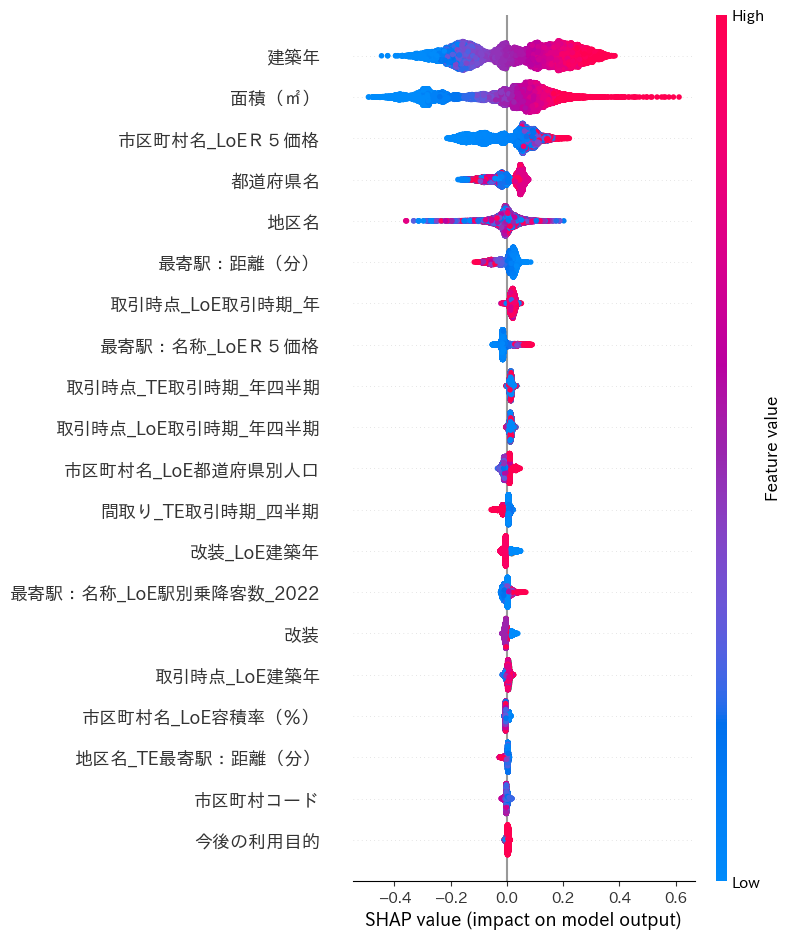

In [20]:
shap.summary_plot(sv_test, test)

## 特徴量100を絞り込む

In [21]:
#clf = model
importance = pd.DataFrame(model.feature_importance(importance_type='gain'), index=test.columns, columns=['importance'])
importance = importance.sort_values('importance', ascending=False)
sorted_idx = np.argsort(importance)
importance_handred = list(sorted_idx[:100].index)
display(importance_handred)

['建築年',
 '地区名',
 '面積（㎡）',
 '市区町村名_LoEＲ５価格',
 '都道府県名',
 '最寄駅：距離（分）',
 '最寄駅：名称_LoEＲ５価格',
 '最寄駅：名称_LoE駅別乗降客数_2022',
 '市区町村名_LoE都道府県別人口',
 '取引時点_LoE取引時期_年',
 '間取り_TE取引時期_四半期',
 '改装_LoE建築年',
 '取引時点_TE取引時期_年四半期',
 '取引時点_LoE建築年',
 '間取り_LoE面積（㎡）',
 '市区町村コード',
 '取引時点_LoE取引時期_年四半期',
 '改装',
 '最寄駅：名称_LoE都道府県別人口',
 '市区町村名_LoE駅別乗降客数_2022',
 'ID',
 '地区名_TE最寄駅：距離（分）',
 '都市計画',
 '地区名_LoE都道府県別人口',
 '取引の事情等_TE取引時期_四半期',
 '改装_LoE取引-建築',
 '今後の利用目的',
 '取引の事情等_TE建築年',
 '取引時点_LoE取引-建築',
 '取引時点_TE建築年',
 '取引時点_TE面積（㎡）',
 '取引の事情等_TE容積率（％）',
 '市区町村名_TE建ぺい率（％）',
 '地区名_TE建築年',
 '改装_LoE取引時期_四半期',
 '今後の利用目的_LoE取引時期_四半期',
 '市区町村名_TE容積率（％）',
 '都道府県名_LoE駅別乗降客数_2022',
 '地区名_LoE最寄駅：距離（分）',
 '最寄駅：名称_TE建ぺい率（％）',
 '今後の利用目的_LoE建築年',
 '都道府県名_TE面積（㎡）',
 '最寄駅：名称_TE容積率（％）',
 '市区町村名_LoE容積率（％）',
 '市区町村コード_LoE取引-建築',
 '都道府県名_LoE都道府県別人口',
 '取引時点_TE建ぺい率（％）',
 '取引時点_TE取引-建築',
 '容積率（％）',
 '建物の構造_LoE建築年',
 '市区町村コード_LoE建築年',
 '取引時点_TE最寄駅：距離（分）',
 '都道府県名_LoE建築年',
 '市区町村名_TE取引時期_年',
 '市区町村名_LoE取引時期_四半期',
 '取引の事情等_TE取引時期_年',
 '市区町村名_TE取引時期_四

In [22]:
with open(path_start/"my_list_100.csv", "w") as f:
    for item in importance_handred:
        f.write(str(item) + "\n")
f.close()